<h1> 1 - Data Engineering 

In [110]:
import numpy as np
import pandas as pd

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [111]:
DATA_PATH = "adult_all.csv"
df = pd.read_csv(DATA_PATH)

print("Data shape:", df.shape)
df.head()

Data shape: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,?,12285,Some-college,10,Never-married,?,Not-in-family,Amer-Indian-Eskimo,Female,0,0,20,United-States,<=50K
1,32,?,13862,HS-grad,9,Never-married,?,Not-in-family,Amer-Indian-Eskimo,Female,0,0,38,United-States,<=50K
2,29,?,19793,Some-college,10,Divorced,?,Unmarried,White,Female,0,0,8,United-States,<=50K
3,18,?,20057,Some-college,10,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,16,United-States,<=50K
4,19,?,20469,HS-grad,9,Never-married,?,Other-relative,Asian-Pac-Islander,Female,0,0,12,South,<=50K


In [112]:
print("Columns:", df.columns.tolist())

TARGET_COL = "income" 
assert TARGET_COL in df.columns, "Target column not found!"

print("Target unique values (raw):", df[TARGET_COL].unique())

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Target unique values (raw): ['<=50K' '>50K']


In [113]:
# data cleaning

df_clean = df.copy()

obj_cols = df_clean.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df_clean[c] = df_clean[c].astype("string").str.strip()
    
df_clean = df_clean.replace("?", "UNKNOWN")

print("After cleaning, sample rows:")
df_clean.head()

After cleaning, sample rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,UNKNOWN,12285,Some-college,10,Never-married,UNKNOWN,Not-in-family,Amer-Indian-Eskimo,Female,0,0,20,United-States,<=50K
1,32,UNKNOWN,13862,HS-grad,9,Never-married,UNKNOWN,Not-in-family,Amer-Indian-Eskimo,Female,0,0,38,United-States,<=50K
2,29,UNKNOWN,19793,Some-college,10,Divorced,UNKNOWN,Unmarried,White,Female,0,0,8,United-States,<=50K
3,18,UNKNOWN,20057,Some-college,10,Never-married,UNKNOWN,Not-in-family,Asian-Pac-Islander,Female,0,0,16,United-States,<=50K
4,19,UNKNOWN,20469,HS-grad,9,Never-married,UNKNOWN,Other-relative,Asian-Pac-Islander,Female,0,0,12,South,<=50K


In [114]:
# حذف ردیف‌هایی که برچسب ندارند
before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=[TARGET_COL])
after = df_clean.shape[0]

print(f"Dropped rows with missing target: {before - after}")
print("New shape:", df_clean.shape)

X = df_clean.drop(columns=[TARGET_COL]).copy()
y = df_clean[TARGET_COL].copy()

print("X shape:", X.shape)
print("y distribution (count):\n", y.value_counts())
print("\ny distribution (ratio):\n", y.value_counts(normalize=True))

Dropped rows with missing target: 0
New shape: (48842, 15)
X shape: (48842, 14)
y distribution (count):
 income
<=50K    37155
>50K     11687
Name: count, dtype: Int64

y distribution (ratio):
 income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: Float64


In [115]:
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Number of features:", X.shape[1])
print("Numeric features:", len(numeric_cols), numeric_cols)
print("Categorical features:", len(categorical_cols), categorical_cols)

Number of features: 14
Numeric features: 6 ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: 8 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [116]:
# خلاصه آماری عددی‌ها
if len(numeric_cols) > 0:
    display(X[numeric_cols].describe().T)

# Missing summary
missing_counts = X.isna().sum().sort_values(ascending=False)
missing_ratio = (missing_counts / len(X)).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_ratio": (missing_ratio * 100).round(2)
})

print("Missing summary (only columns with missing > 0):")
display(missing_summary[missing_summary["missing_count"] > 0])

rows_with_missing = X.isna().any(axis=1).mean()
print(f"Rows with at least one missing value: {rows_with_missing*100:.2f}%")

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643196,13.711223,4.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


Missing summary (only columns with missing > 0):


,missing_count,missing_ratio


Rows with at least one missing value: 0.00%


In [117]:
print("Final dataset shape:", df_clean.shape)
print("X shape:", X.shape, "y shape:", y.shape)

print("\nNumeric features (final):", len(numeric_cols), numeric_cols)
print("Categorical features (final):", len(categorical_cols), categorical_cols)

print("\nTarget distribution (ratio):")
print(y.value_counts(normalize=True))

missing_counts = X.isna().sum()
missing_ratio = (missing_counts / len(X) * 100).round(2)
missing_summary = pd.DataFrame({"missing_count": missing_counts, "missing_ratio(%)": missing_ratio})
print("\nMissing columns (missing_count > 0):")
display(missing_summary[missing_summary["missing_count"] > 0].sort_values("missing_count", ascending=False))

Final dataset shape: (48842, 15)
X shape: (48842, 14) y shape: (48842,)

Numeric features (final): 6 ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (final): 8 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Target distribution (ratio):
income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: Float64



Missing columns (missing_count > 0):


,missing_count,missing_ratio(%)


<h1> 2 - Feature Engineering

In [120]:
# Create a new feature: net capital income (gain - loss)
# This feature represents overall investment-related income

df_fe = df_clean.copy()

df_fe["capital_total"] = df_fe["capital-gain"] - df_fe["capital-loss"]

df_fe[["capital-gain", "capital-loss", "capital_total"]].head()

,capital-gain,capital-loss,capital_total
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [121]:
df_fe[df_fe["capital_total"] != 0][
    ["capital-gain", "capital-loss", "capital_total"]
].head()

,capital-gain,capital-loss,capital_total
15,0,1719,-1719
27,2936,0,2936
31,0,2415,-2415
37,2228,0,2228
48,9386,0,9386


In [122]:
# Update X and y after feature creation
X = df_fe.drop(columns=[TARGET_COL]).copy()
y = df_fe[TARGET_COL].copy()

print("New X shape after feature creation:", X.shape)

New X shape after feature creation: (48842, 15)


In [123]:
# Update lists of numeric and categorical features after feature creation
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric features (updated):", len(numeric_cols), numeric_cols)
print("Categorical features:", len(categorical_cols), categorical_cols)

Numeric features (updated): 7 ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'capital_total']
Categorical features: 8 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [124]:
from sklearn.model_selection import train_test_split

# Final split for modeling (after all manual feature engineering)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("capital_total in train?", "capital_total" in X_train.columns)

Train shape: (39073, 15)  Test shape: (9769, 15)
capital_total in train? True


In [125]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline for numerical features
# 1. Impute missing values using median
# 2. Apply standard scaling
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical features
# 1. Impute missing values using most frequent category
# 2. Apply One-Hot Encoding
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(
        handle_unknown="ignore", 
        sparse_output=False
    ))
])

# Combine both pipelines
# This ensures correct preprocessing for each feature type
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [126]:
# Fit preprocessing only on training data to avoid leakage
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("Before preprocessing:", X_train.shape)
print("After preprocessing:", X_train_prep.shape)

Before preprocessing: (39073, 15)
After preprocessing: (39073, 109)


In [127]:
# Get feature names after One-Hot Encoding
cat_feature_names = preprocessor.named_transformers_["cat"] \
    .named_steps["encoder"] \
    .get_feature_names_out(categorical_cols)

final_feature_names = numeric_cols + list(cat_feature_names)

print("Total number of final features:", len(final_feature_names))
print("\nSample features:")
final_feature_names[:20]

Total number of final features: 109

Sample features:


['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'capital_total',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_UNKNOWN',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th']

In [128]:
comparison_df = pd.DataFrame({
    "Stage": ["Before Feature Engineering", "After Feature Engineering"],
    "Number of samples": [X_train.shape[0], X_train_prep.shape[0]],
    "Number of features": [X_train.shape[1], X_train_prep.shape[1]]
})

comparison_df

,Stage,Number of samples,Number of features
0,Before Feature Engineering,39073,15
1,After Feature Engineering,39073,109


<h1> 3 - Unsupervised Learning (PCA)

In [129]:
from sklearn.decomposition import PCA
import numpy as np

# PCA is unsupervised: we do NOT use y for fitting
pca = PCA(random_state=RANDOM_SEED)

pca.fit(X_train_prep)

explained_var_ratio = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var_ratio)

print("First 10 explained variance ratios:")
print(np.round(explained_var_ratio[:10], 4))

print("\nCumulative explained variance (first 10 components):")
print(np.round(cum_explained[:10], 4))

First 10 explained variance ratios:
[0.1834 0.1246 0.0975 0.0888 0.082  0.0769 0.0533 0.0264 0.0233 0.0213]

Cumulative explained variance (first 10 components):
[0.1834 0.308  0.4055 0.4943 0.5763 0.6532 0.7065 0.7328 0.7562 0.7775]


In [130]:
# Choose number of components that explain ~90% of variance
n_90 = int(np.argmax(cum_explained >= 0.90) + 1)
n_95 = int(np.argmax(cum_explained >= 0.95) + 1)

print("Components needed for 90% variance:", n_90)
print("Components needed for 95% variance:", n_95)

Components needed for 90% variance: 21
Components needed for 95% variance: 31


In [131]:
pca_2 = PCA(n_components=2, random_state=RANDOM_SEED)

X_train_pca2 = pca_2.fit_transform(X_train_prep)
X_test_pca2 = pca_2.transform(X_test_prep)

print("X_train_pca2 shape:", X_train_pca2.shape)

X_train_pca2 shape: (39073, 2)


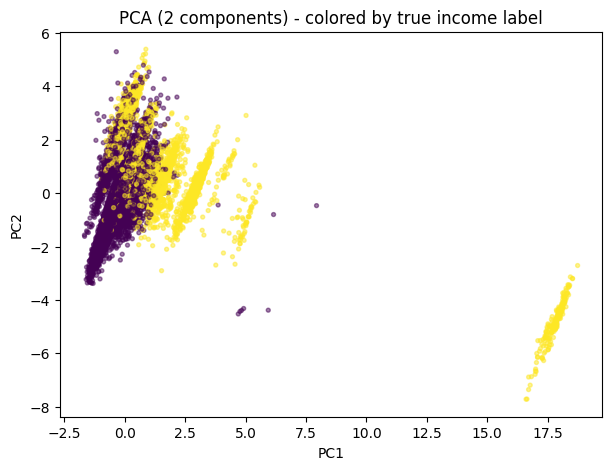

In [132]:
import matplotlib.pyplot as plt

# We color points by true label ONLY for analysis/interpretation
y_train_array = y_train.to_numpy()

plt.figure(figsize=(7, 5))
plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], s=8, alpha=0.5, c=(y_train_array == ">50K"))
plt.title("PCA (2 components) - colored by true income label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [133]:
import pandas as pd

pca_df = pd.DataFrame(X_train_pca2, columns=["PC1", "PC2"])
pca_df["income"] = y_train.values

summary = pca_df.groupby("income")[["PC1", "PC2"]].mean()
summary

,PC1,PC2
income,,
<=50K,-0.286128,-0.255062
>50K,0.909709,0.810938


<h1> 4 - supervised Learning (Logistic Regression, Decision Tree, KNN)

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
import numpy as np

In [146]:
from sklearn.pipeline import Pipeline

# Logistic Regression pipeline
logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
])

# Decision Tree pipeline
tree_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(random_state=RANDOM_SEED))
])

# KNN pipeline
knn_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

In [147]:

models = {
    "Logistic Regression": logreg_pipe,
    "Decision Tree": tree_pipe,
    "KNN": knn_pipe
}

cv_results = {}

for name, model in models.items():
    print(f"Running CV for {name}...")
    f1_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='f1')
    cv_results[name] = f1_scores

# نتایج F1 برای هر مدل
for name, scores in cv_results.items():
    print(f"{name} - Mean F1 Score: {scores.mean()} (Std: {scores.std()})")

Running CV for Logistic Regression...
Running CV for Decision Tree...
Running CV for KNN...
Logistic Regression - Mean F1 Score: 0.6634735616639709 (Std: 0.006528264442405818)
Decision Tree - Mean F1 Score: 0.6183288136123151 (Std: 0.0075695702863719395)
KNN - Mean F1 Score: 0.639561911220375 (Std: 0.01048303153896601)


In [148]:

results_list = []

for name, scores in cv_results.items():
   
    accuracy = cross_val_score(models[name], X_train, y_train_encoded, cv=5, scoring='accuracy')
    roc_auc = cross_val_score(models[name], X_train, y_train_encoded, cv=5, scoring='roc_auc')
    
    row = {
        "Model": name,
        "Accuracy (mean)": accuracy.mean(),
        "Accuracy (std)": accuracy.std(),
        "F1 (mean)": scores.mean(),
        "F1 (std)": scores.std(),
        "ROC-AUC (mean)": roc_auc.mean(),
        "ROC-AUC (std)": roc_auc.std()
    }
    
    results_list.append(row)


results_df = pd.DataFrame(results_list)

In [ ]:
results_df_sorted = results_df.sort_values(by="F1 (mean)", ascending=False)

results_df_sorted

,Model,Accuracy (mean),Accuracy (std),F1 (mean),F1 (std),ROC-AUC (mean),ROC-AUC (std)
0,Logistic Regression,0.853582,0.002544,0.663474,0.006528,0.906329,0.004325
2,KNN,0.836486,0.003879,0.639562,0.010483,0.862981,0.004248
1,Decision Tree,0.815294,0.003830,0.618329,0.007570,0.750166,0.005103
